<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Общие-выводы" data-toc-modified-id="Общие-выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общие выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>


# Прогнозирование заказов такси


Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики _RMSE_ на тестовой выборке должно быть не больше 48.

**Цель данной работы** - решение регрессионной задачи прогнозирования временных рядов с целью предсказания количества заказов такси.

Для её реализации необходимо выполнить следующие **задачи**:

1. Загрузить данные и пересемплировать их по одному часу.
2. Проанализировать данные.
3. Обучить различные модели и подобрать для них оптимальные гиперпараметры для обеспечения метрики RMSE.
4. Тестовую выборку сделать 10% от исходных данных и проверить на ней качество предсказания.


## Подготовка


Установка необходимых библиотек:


In [1]:
!pip install optuna  -q
# !pip install --upgrade scikit-learn --user -q
# !pip install catboost==1.1.1 --user -q

In [2]:
# Мои версии библиотек, если вдруг что-то не запустится
# optuna==3.1.0
# catboost==1.1.1
# lightgbm==3.3.4
# scikit-learn==1.2.1
# xgboost==1.7.3

Импорт библиотек


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression

from lightgbm import LGBMRegressor
from lightgbm import log_evaluation, early_stopping
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

import warnings

warnings.filterwarnings("ignore")

Необходимые надстройки:


In [4]:
# Повышает качество рисунков
%config InlineBackend.figure_format = 'retina'

# Увеличивает размер шрифта на графиках
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (15, 8)

# Устанавливаем цветовую палитру и стиль
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# Устанавливаем число для генераторов рандома
RND = 100

Считаем данные, преобразуем строки в даты и сделаем их индексами, дополнительно сгруппировав их по 1 часу:


In [5]:
df = pd.read_csv(
    "https://code.s3.yandex.net/datasets/taxi.csv", parse_dates=[0], index_col=[0]
)
df = df.sort_index().resample("1H").sum()
df.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71


Общая информация о преобразованных данных:


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Основные статистики:


In [7]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


### Вывод

Данные загружены и преобразованы к более удобному формату, пропуски, дубликаты отсутствуют.


## Анализ


Теперь взглянем на точечную диаграмму


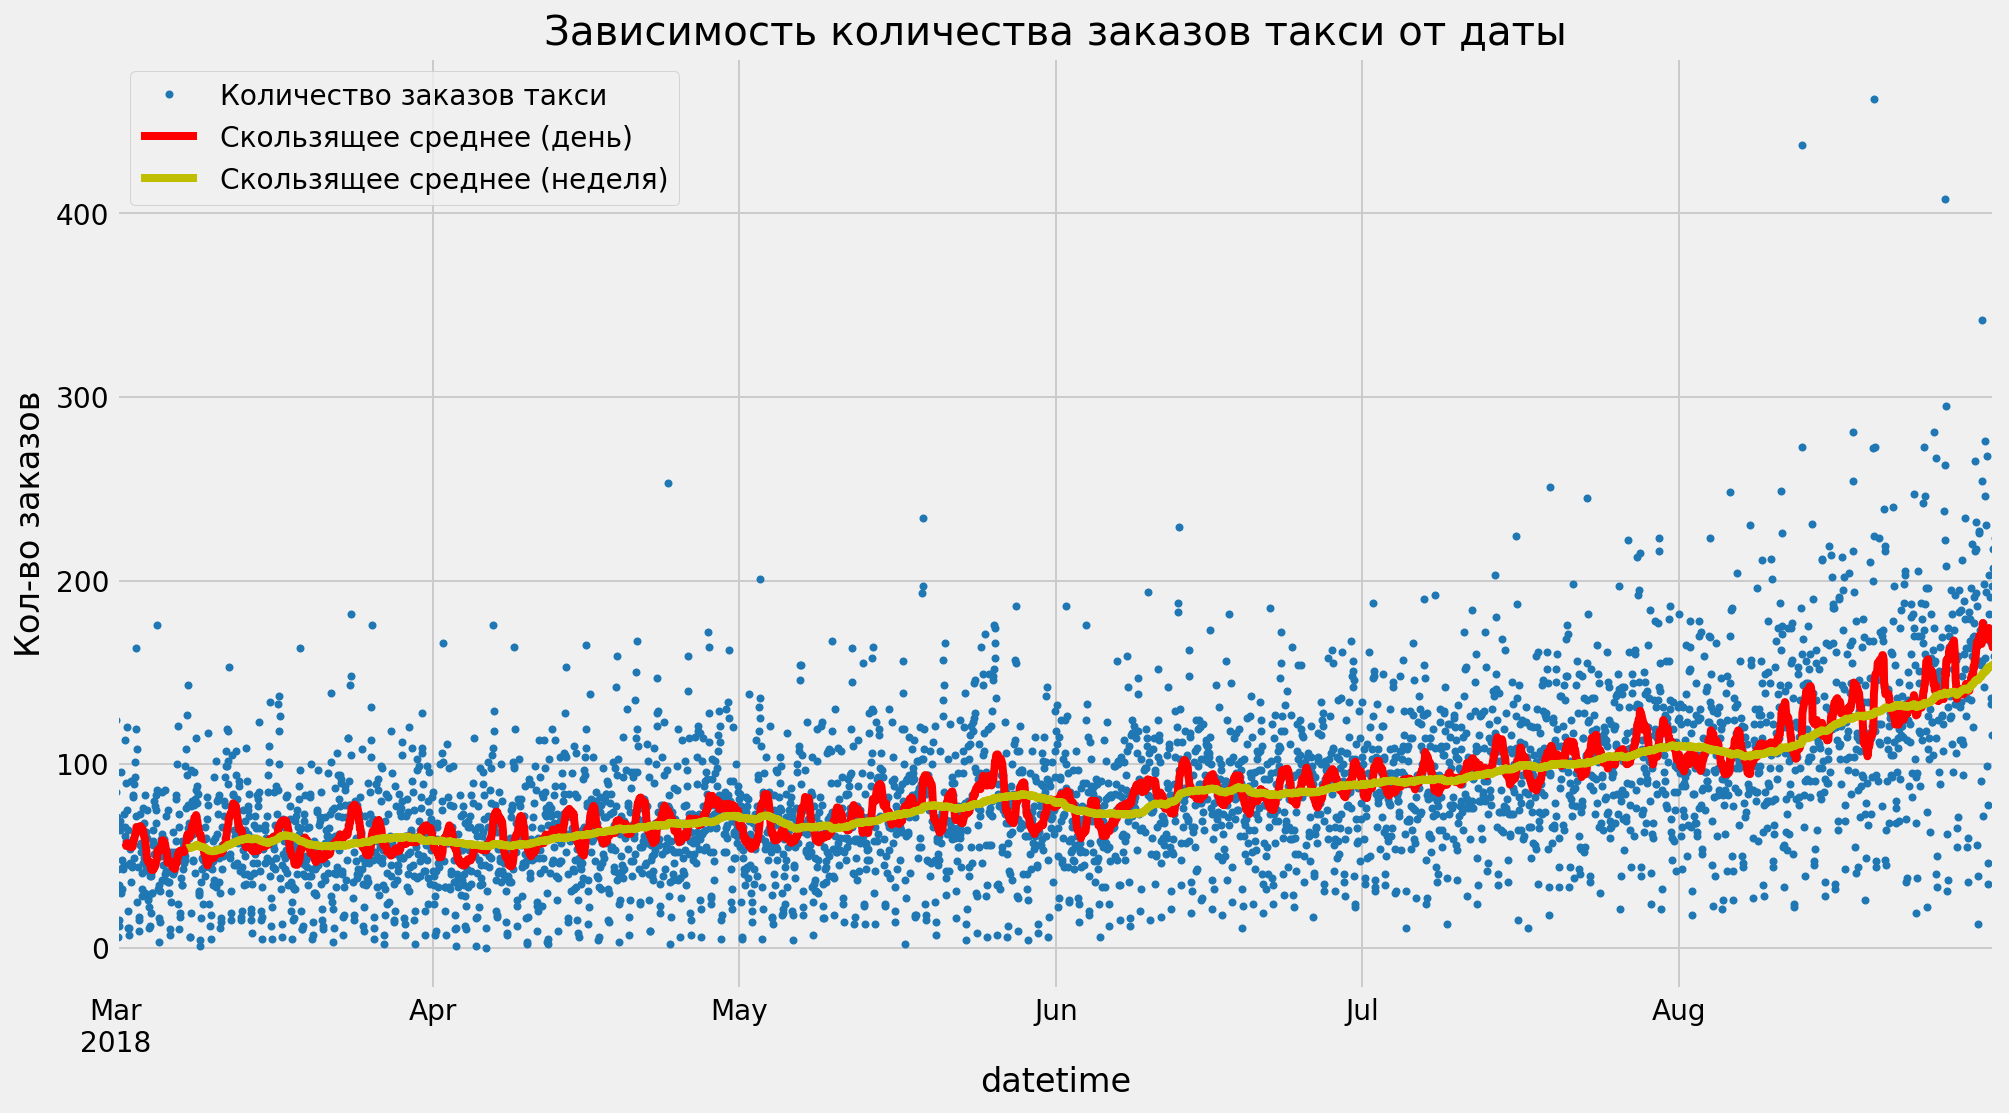

In [8]:
df.plot(
    style=".",
    color=color_pal[0],
    ylabel="Кол-во заказов",
    title="Зависимость количества заказов такси от даты",
)
df["num_orders"].rolling(window=24).mean().plot(color="r")
df["num_orders"].rolling(window=24 * 7).mean().plot(color="y")
plt.legend(
    [
        "Количество заказов такси",
        "Скользящее среднее (день)",
        "Скользящее среднее (неделя)",
    ]
)

Наблюдается тренд к увеличению количества заказов к лету, но для более качественного анализа проведём декомпозицию:


In [9]:
seasonal_decomposed_df = seasonal_decompose(df)

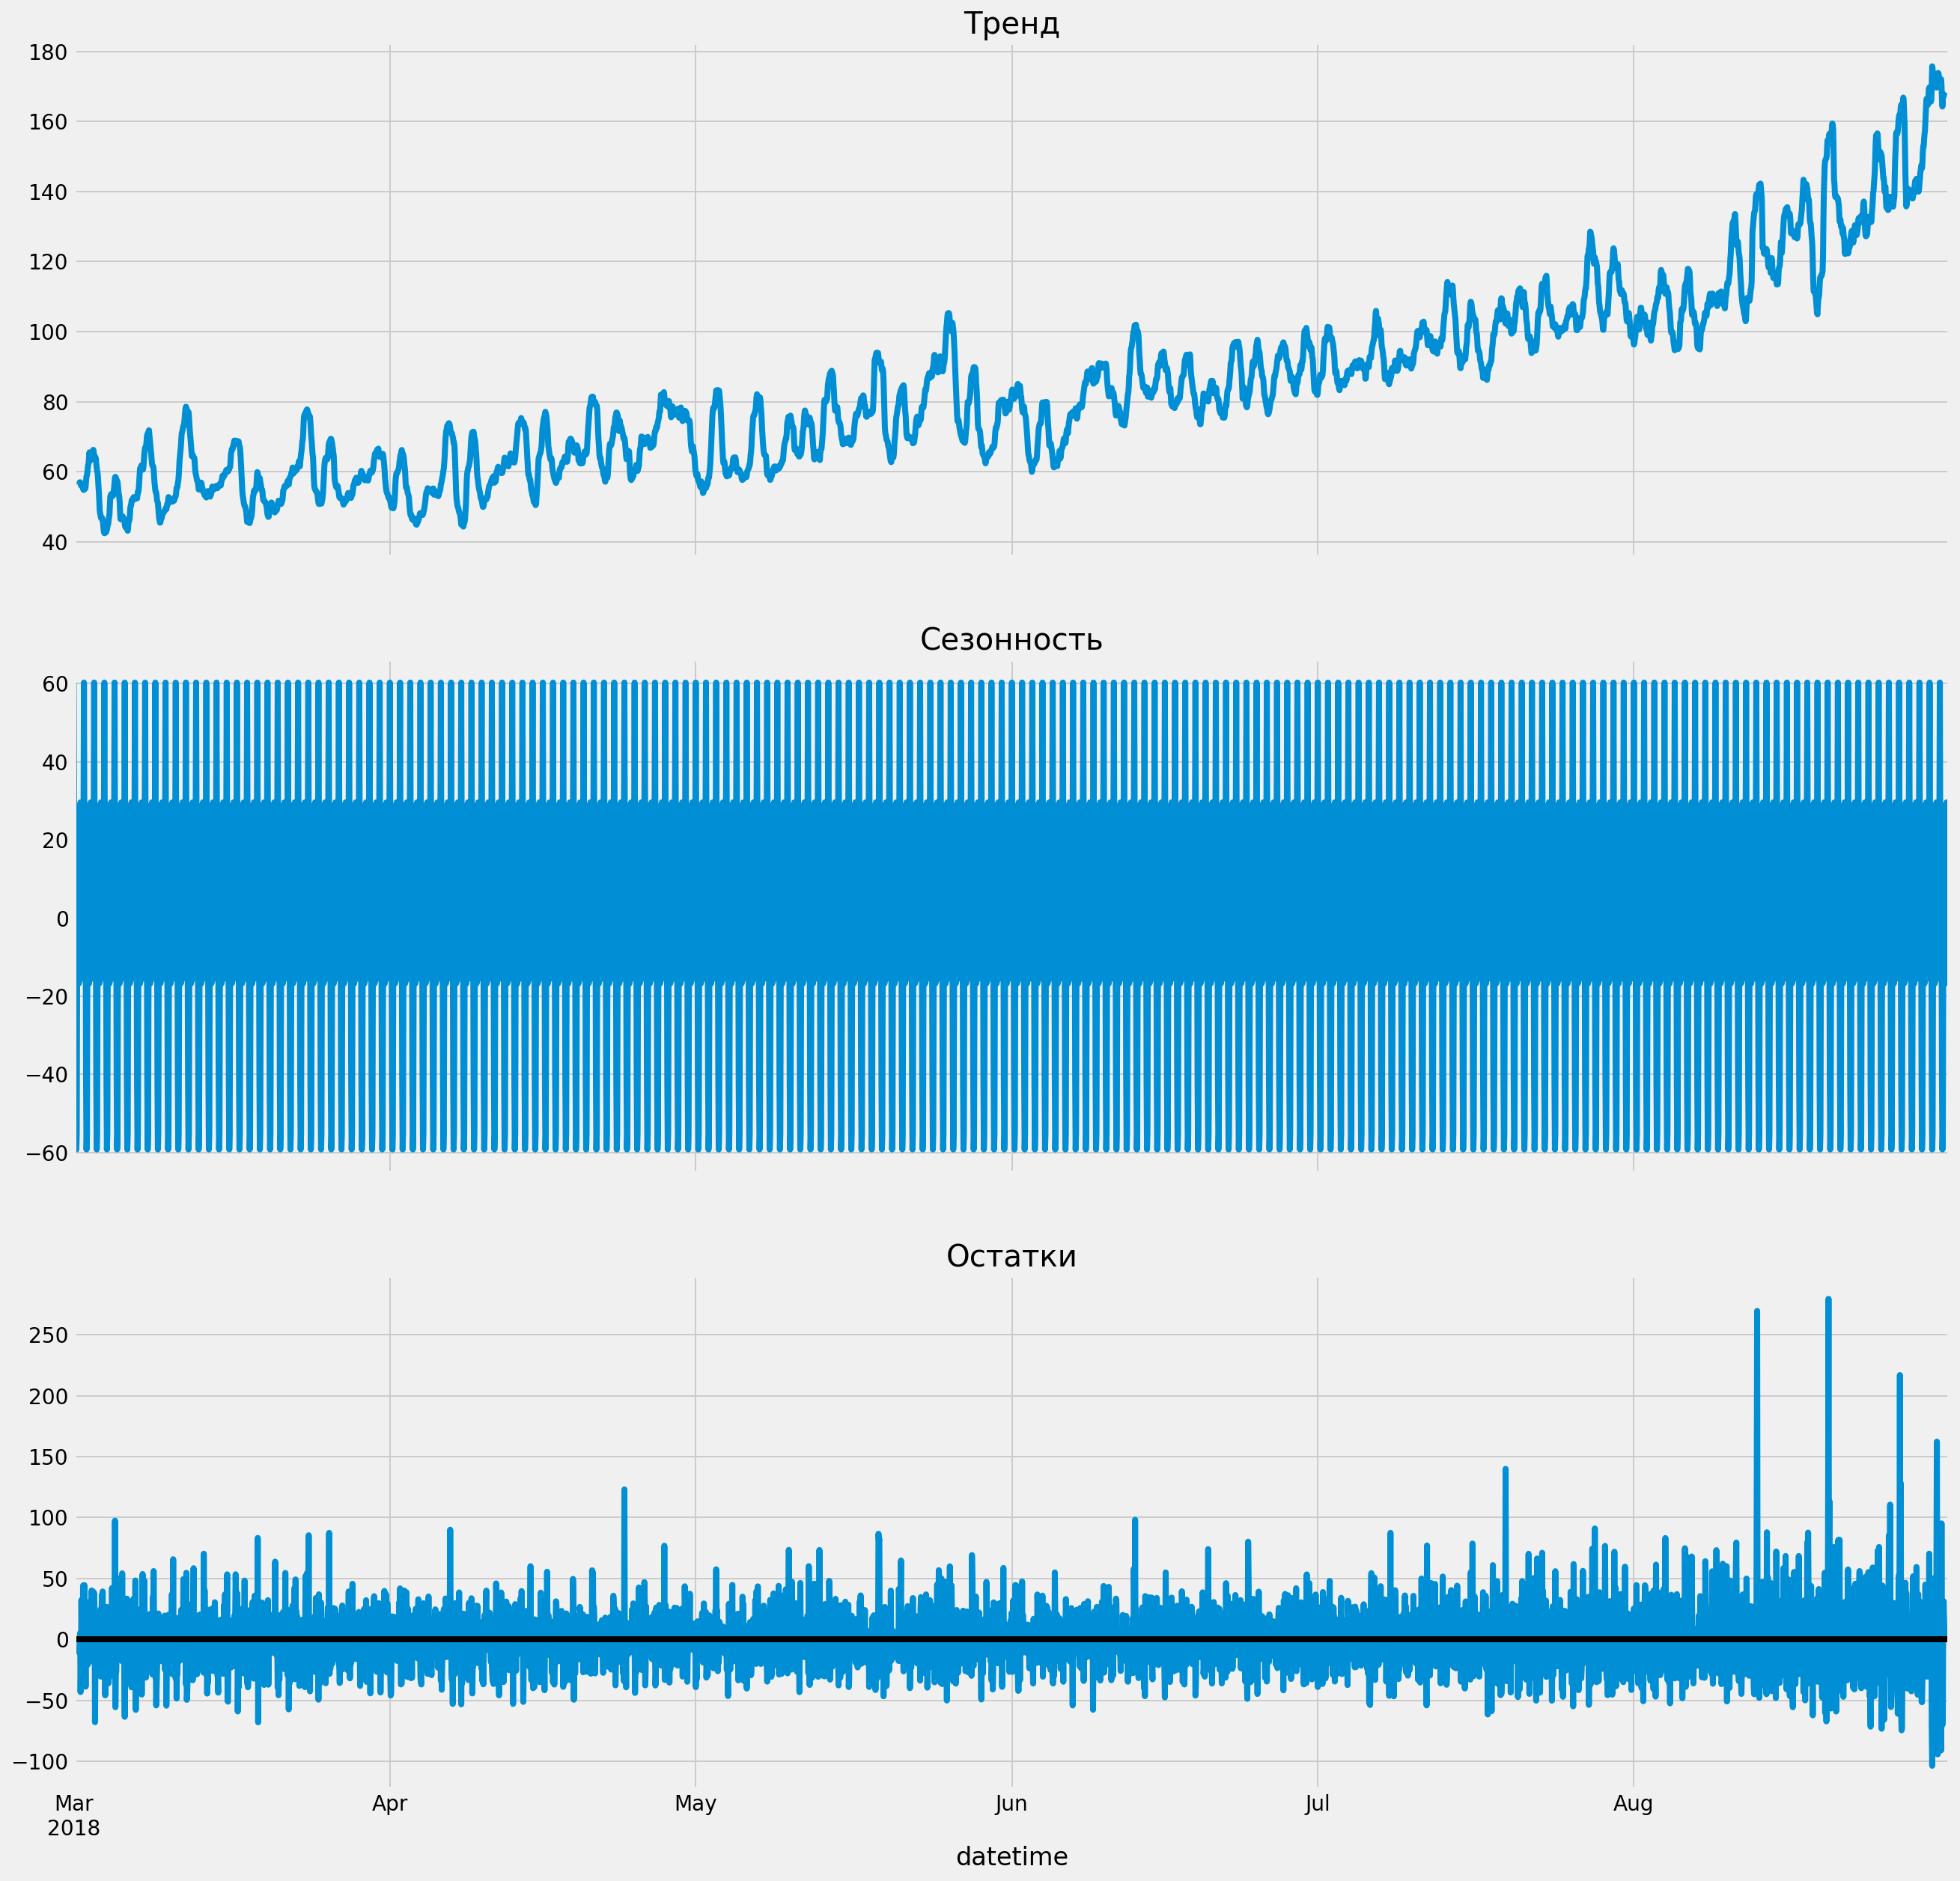

In [10]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(20, 20))
seasonal_decomposed_df.trend.plot(ax=axs[0], title="Тренд")
seasonal_decomposed_df.seasonal.plot(ax=axs[1], title="Сезонность")
seasonal_decomposed_df.resid.plot(ax=axs[2], title="Остатки")
axs[2].axhline(0, color="k")

In [11]:
df[df.num_orders > 300]

,num_orders
datetime,
2018-08-13 02:00:00,437
2018-08-20 02:00:00,462
2018-08-27 02:00:00,408
2018-08-30 17:00:00,342


Как и предполагалось, имеется явный тренд к увеличению кол-ва заказов, а шумы/остатки достаточно стабильны во временем, за исключением 4 аномалий. Вглянем на сезонность в последние дни более пристально:


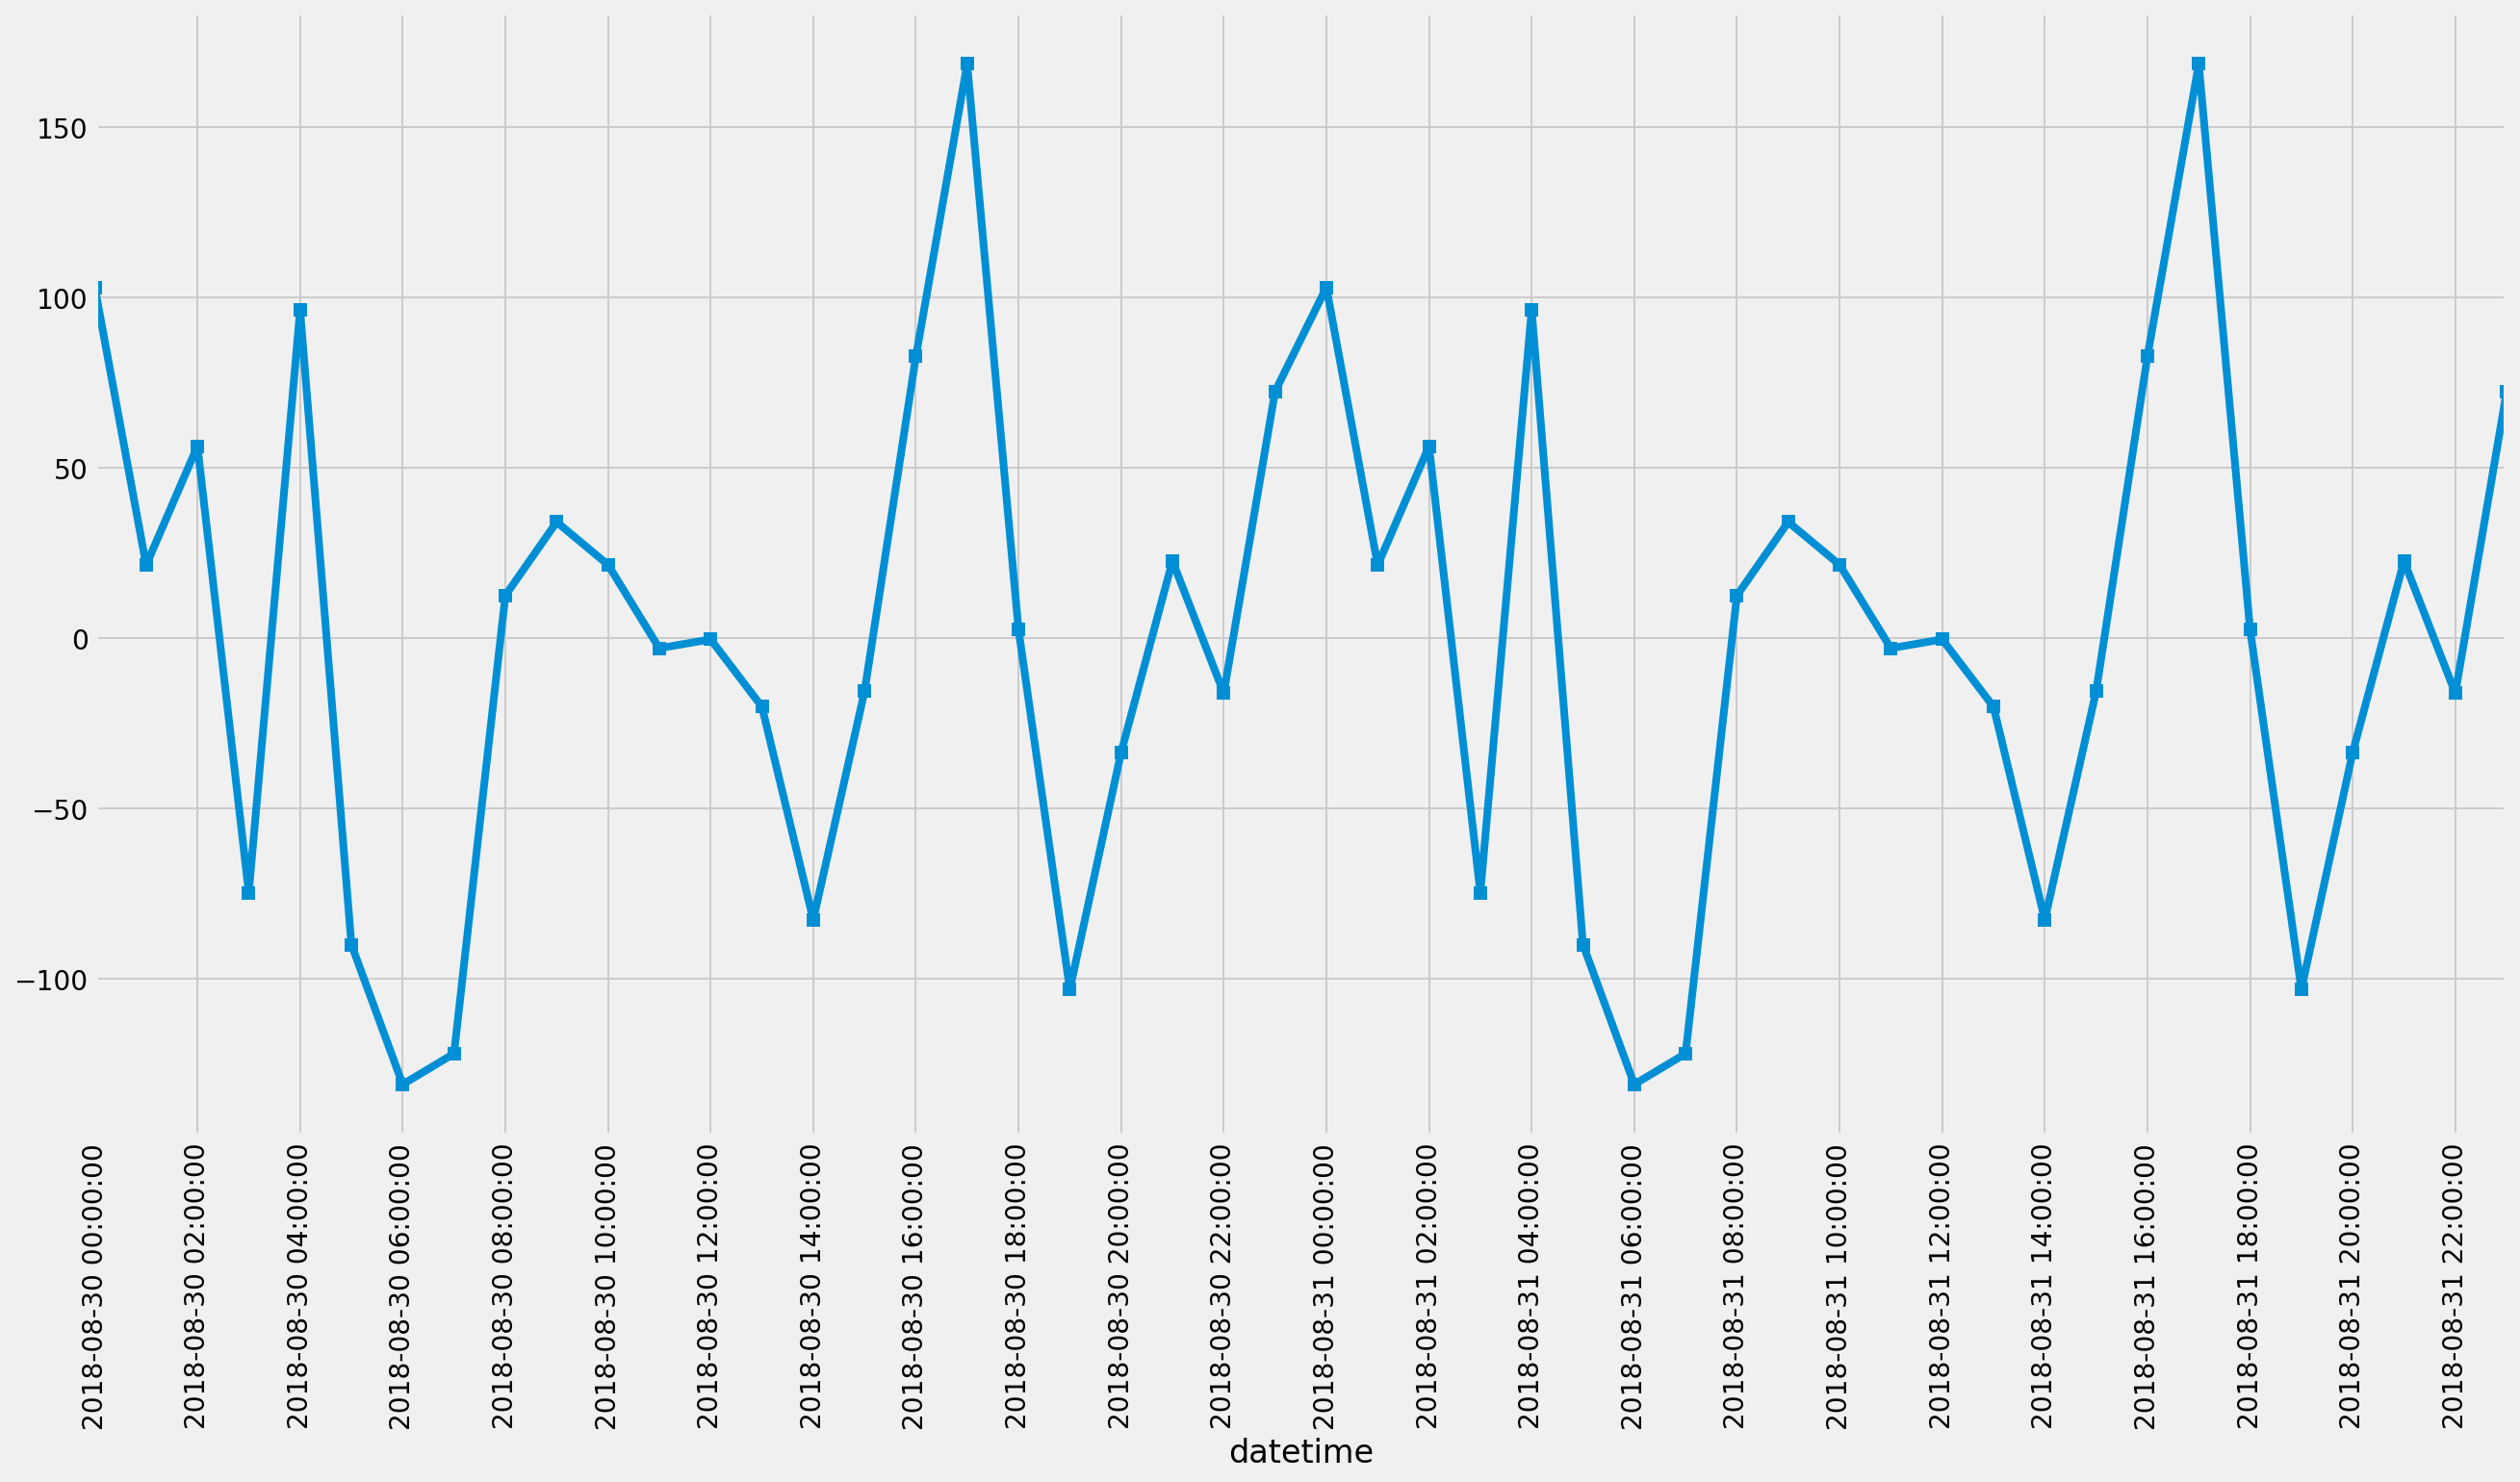

In [12]:
(
    seasonal_decompose(df[df.index >= "2018-08-30"]).seasonal.plot(
        xticks=df[df.index >= "2018-08-30"].index,
        style="-s",
        figsize=(20, 10),
        grid=True,
    )
)
plt.xticks(
    df[df.index >= "2018-08-30"].index[::2],
    labels=df[df.index >= "2018-08-30"].index[::2],
    rotation=90,
)

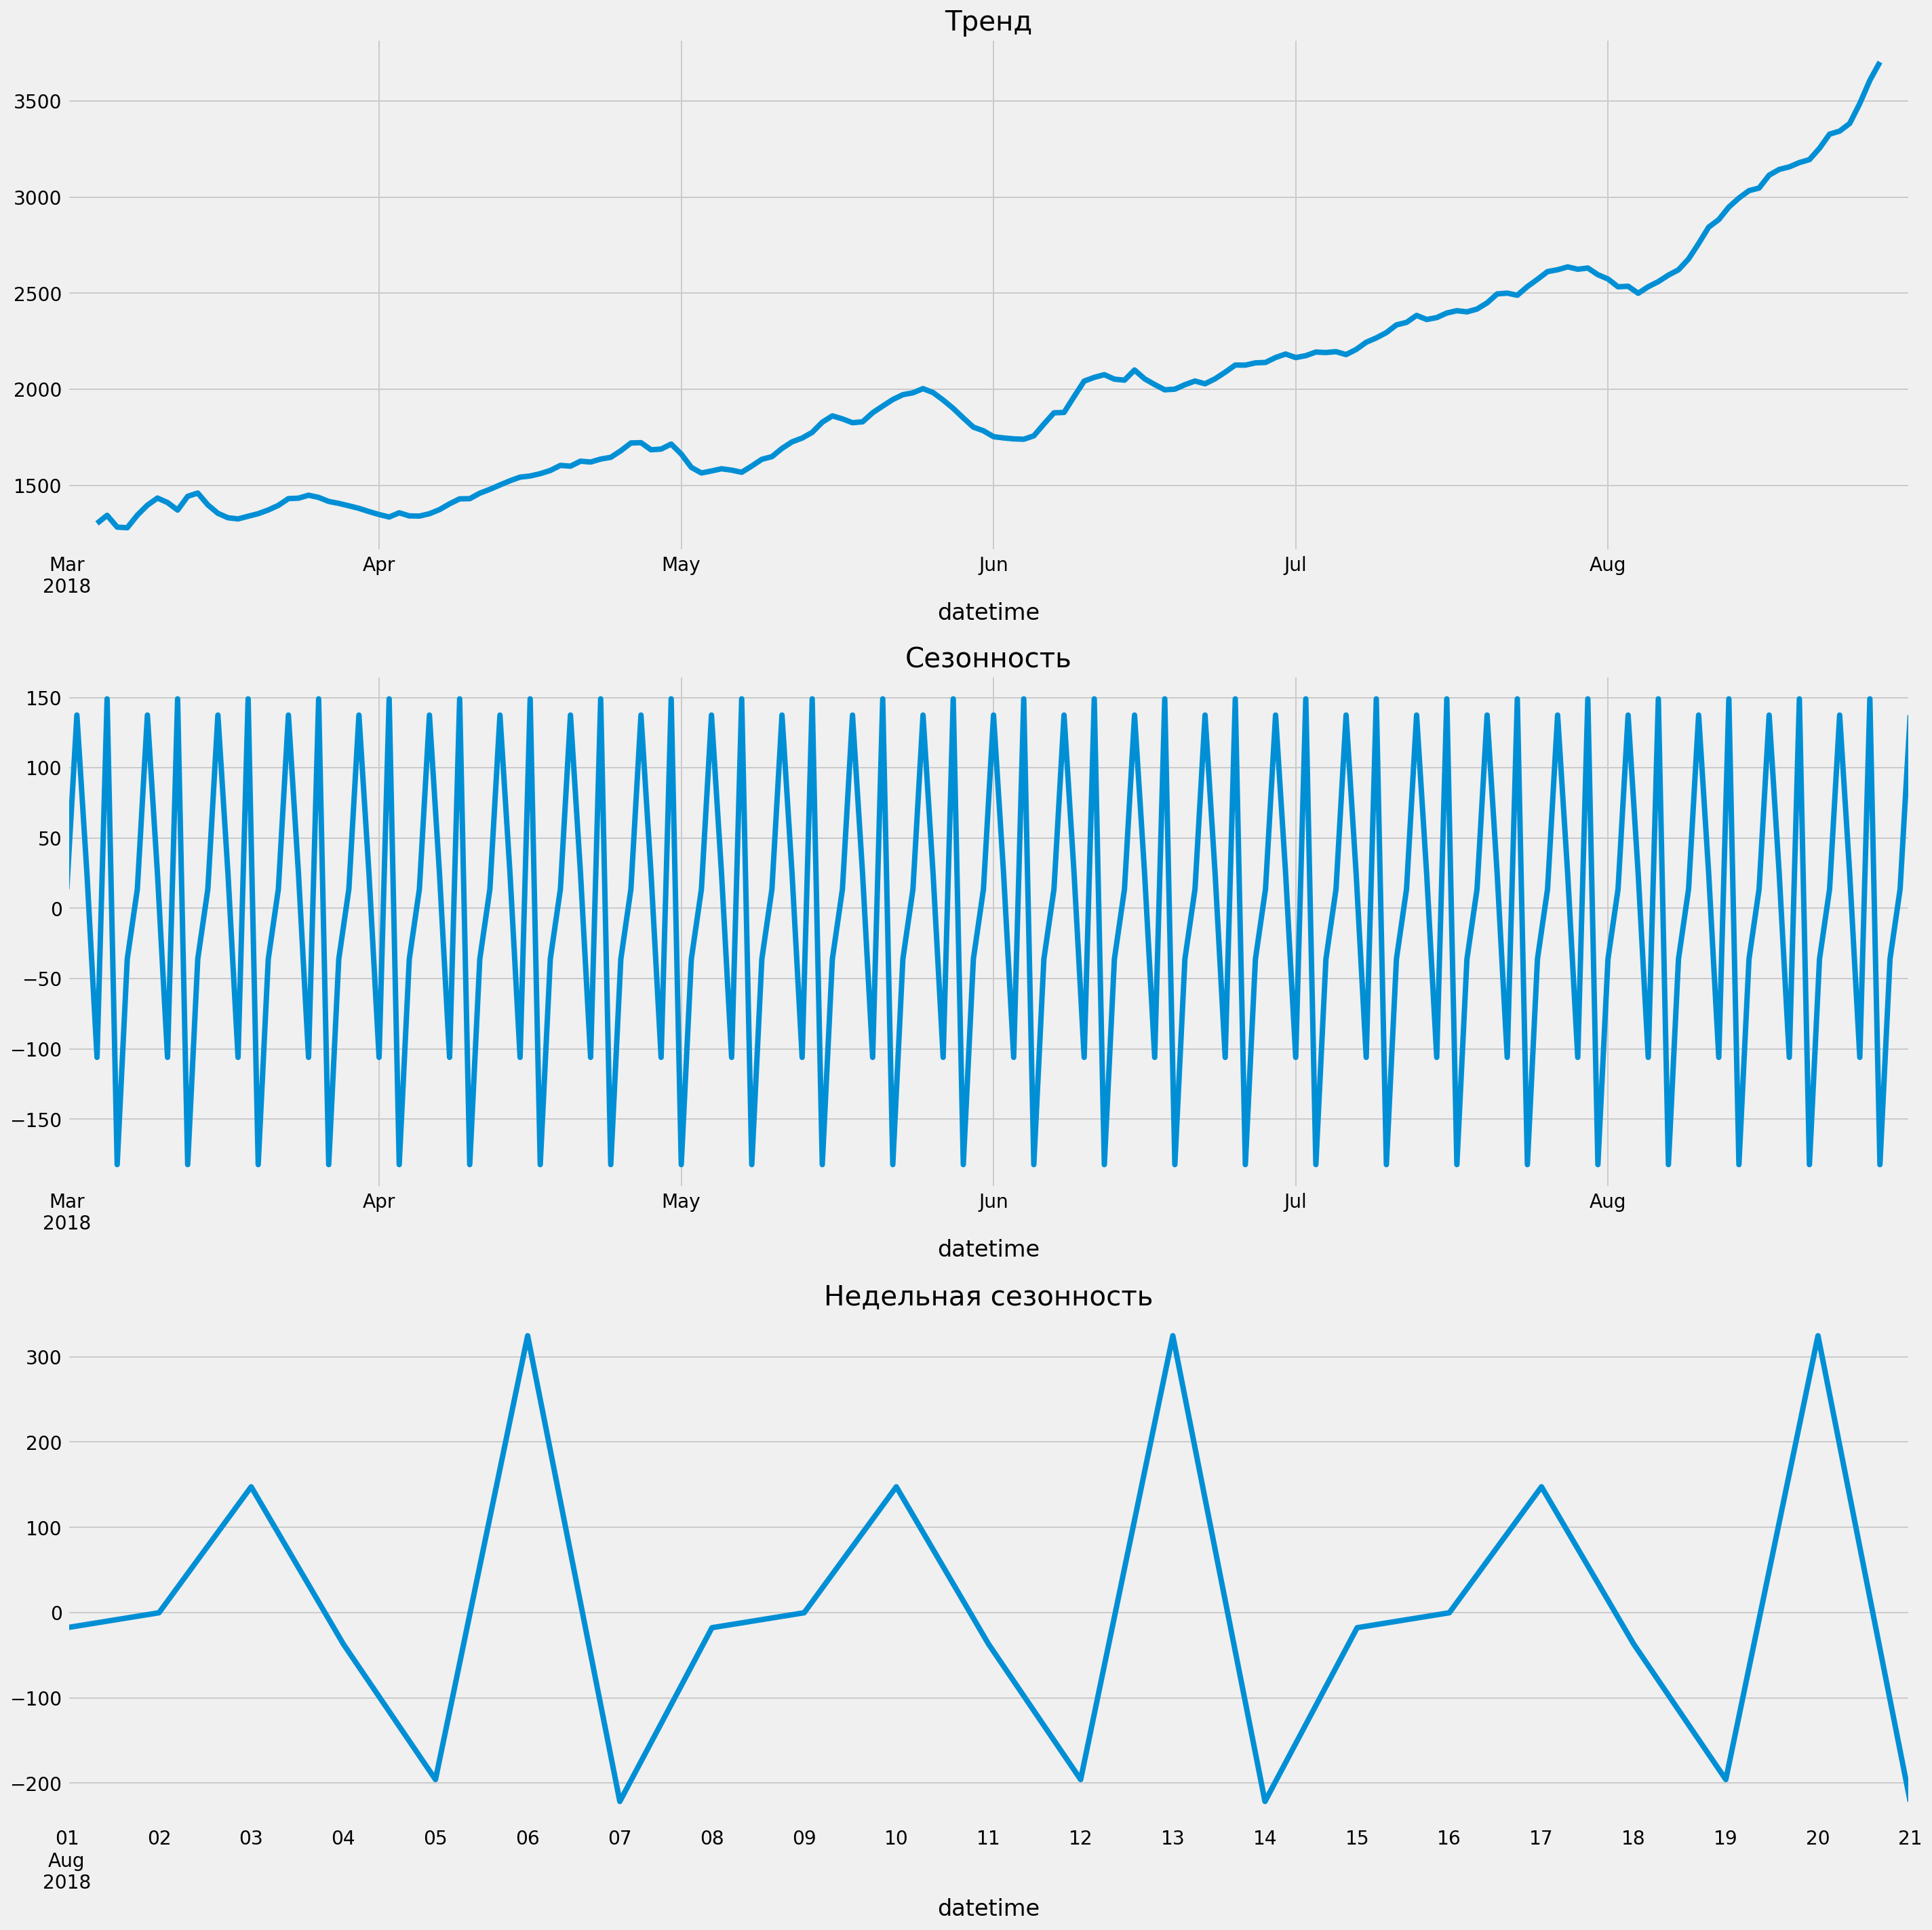

In [13]:
df_day = df.resample("24h").sum()
seasonal_day_df = seasonal_decompose(df_day)
fig, axs = plt.subplots(3, 1, figsize=(20, 20))
seasonal_day_df.trend.plot(ax=axs[0], title="Тренд")
seasonal_day_df.seasonal.plot(ax=axs[1], title="Сезонность")
seasonal_decompose(
    df_day[(df_day.index >= "2018-08-01") & (df_day.index < "2018-08-22")]
).seasonal.plot(ax=axs[2], title="Недельная сезонность")
plt.tight_layout()

Пики заказов в 4 утра и 17 вечера, в то время как минимальное кол-во заказов обычно в 6 утра и 14, 19 часов.


Поскольку кроме даты никаких признаков нет, то их создадим искуственно с помощью функций из даты, значения лагов и размера окна для скользящего среднего будем потом подбирать в рамках оптимизации моделей:


In [14]:
def create_features(df):
    df = df.copy()
    df["hour"] = df.index.hour
    df["day_of_week"] = df.index.dayofweek

    return df.dropna()


def add_lag_and_rolling_mean(df, max_lag=1, rolling_mean_size=1):
    df = df.copy()
    for lag in range(1, max_lag + 1):
        df[f"lag_{lag}"] = df["num_orders"].shift(lag)

    df["rolling_mean"] = df["num_orders"].shift().rolling(rolling_mean_size).mean()

    return df.dropna()


create_features(df)

,num_orders,hour,day_of_week
datetime,,,
2018-03-01 00:00:00,124,0,3
2018-03-01 01:00:00,85,1,3
2018-03-01 02:00:00,71,2,3
2018-03-01 03:00:00,66,3,3
2018-03-01 04:00:00,43,4,3
...,...,...,...
2018-08-31 19:00:00,136,19,4
2018-08-31 20:00:00,154,20,4
2018-08-31 21:00:00,159,21,4


Функция работает корректно, поэтому изучим новые признаки:


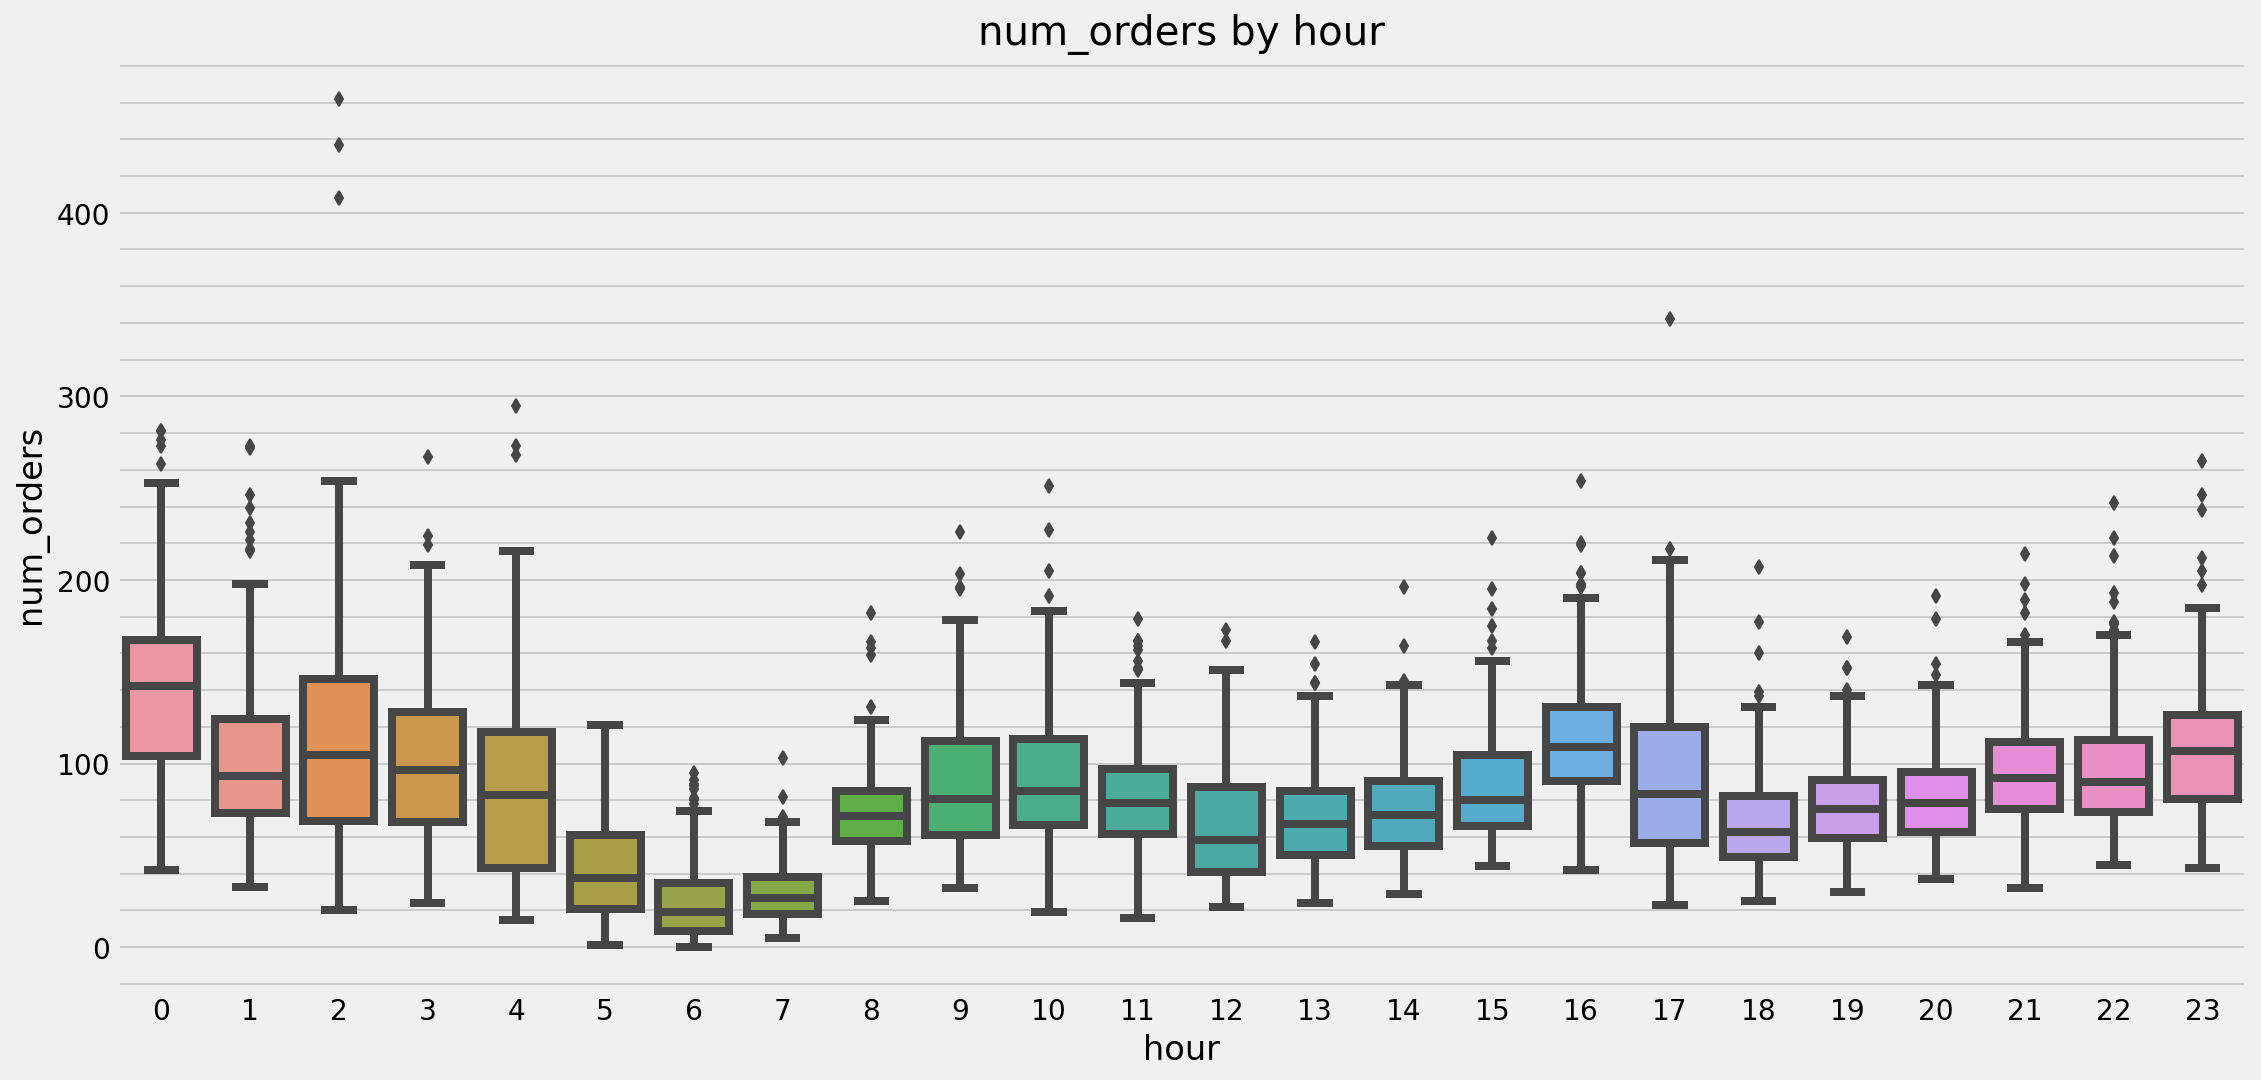

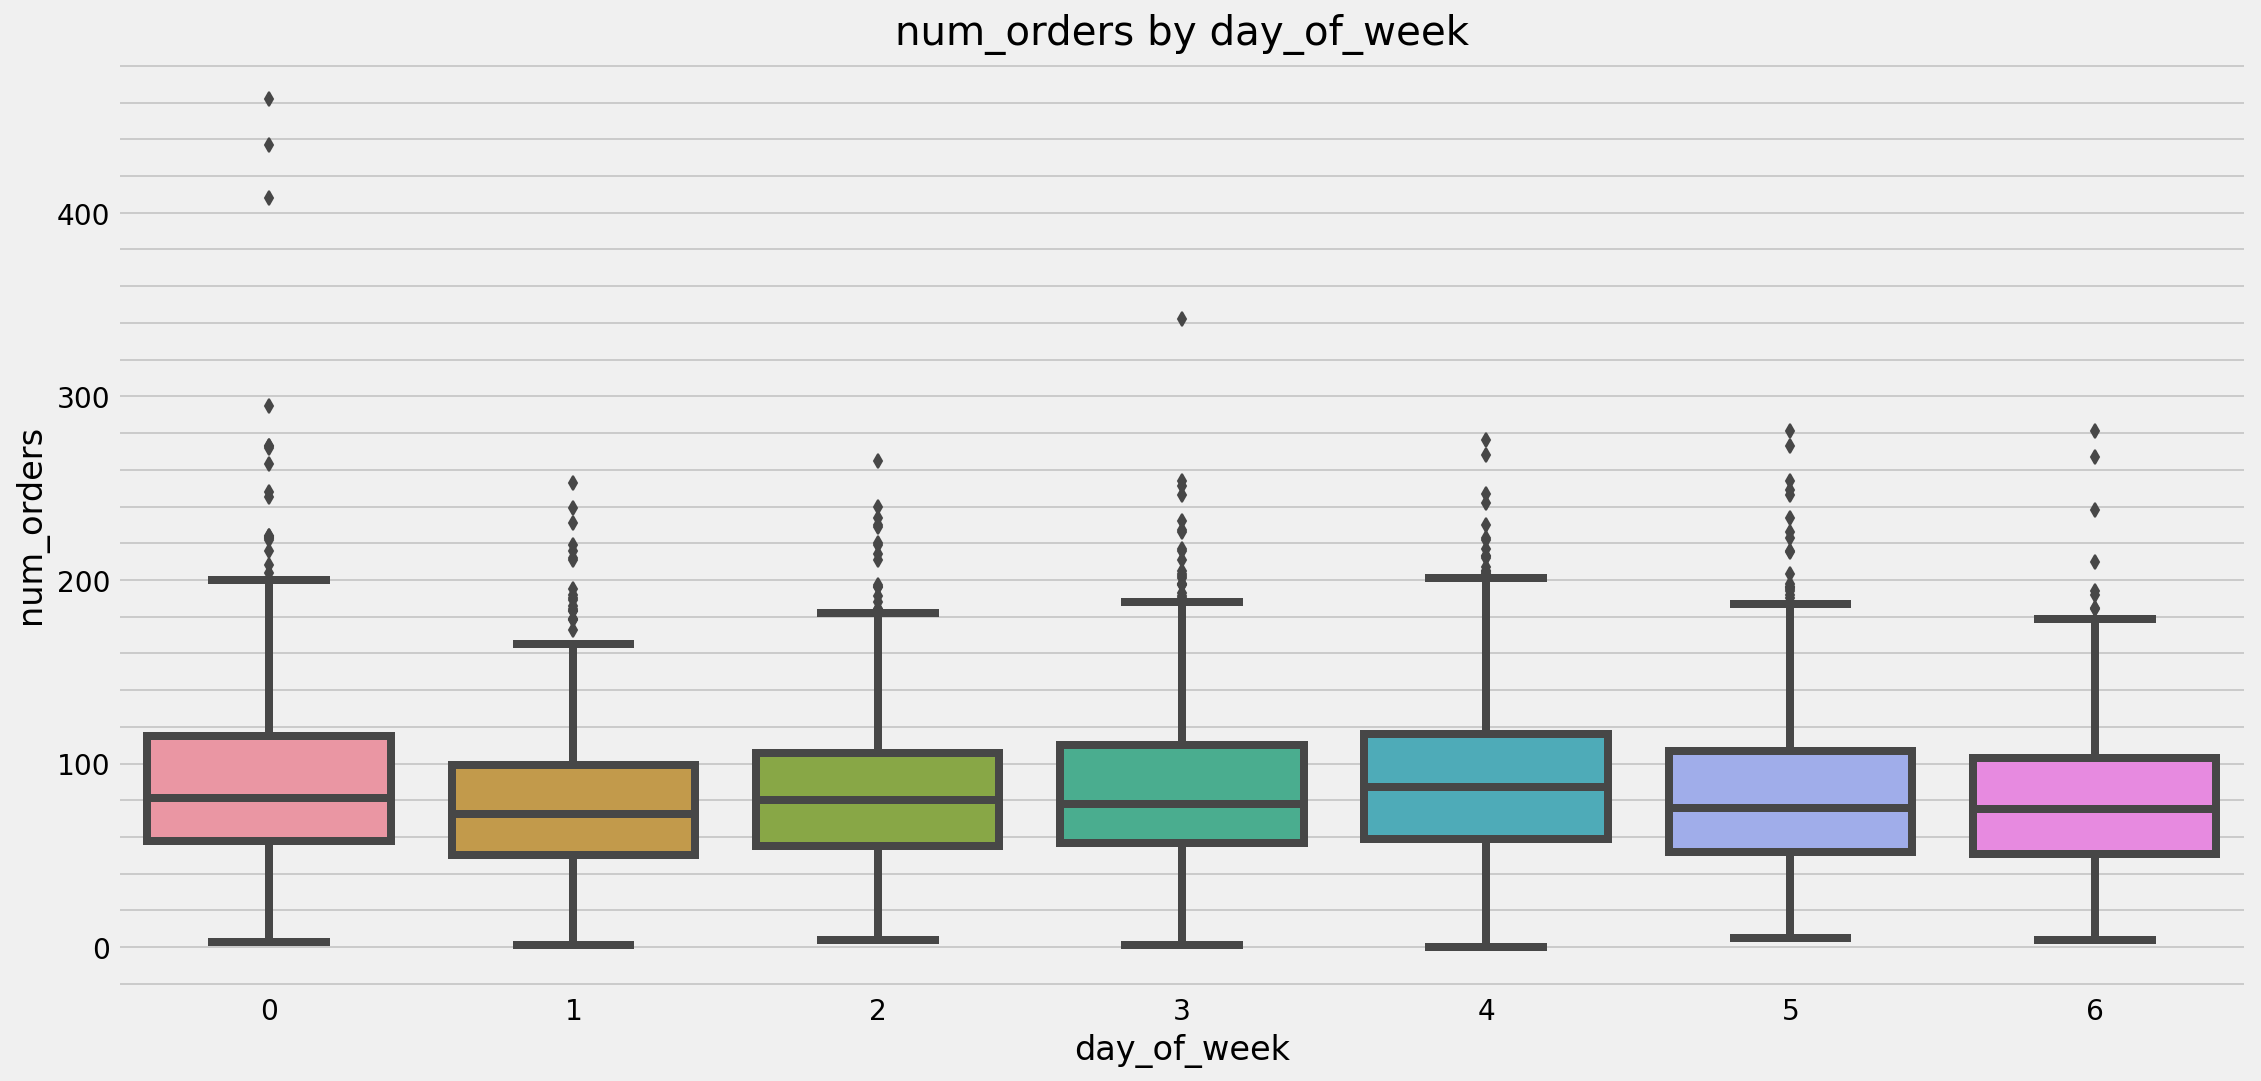

In [15]:
for i in ["hour", "day_of_week"]:
    fig, ax = plt.subplots(figsize=(17, 8))
    sns.boxplot(data=create_features(df), x=i, y="num_orders")
    ax.set_title(f"num_orders by {i}")
    ax.minorticks_on()
    ax.grid(True, axis="y", which="both")
    ax.set_axisbelow(True)
    plt.show()

Из графиков можно заключить следующее:

1. 'hour': с 0 до 6 утра наблюдается спад заказов, потом немного повышается до 10 утра, проседает в обеденное время и в районе 16 случается пик заказов, который плавно падает к 18-19 часам и снова немного набирает к ночи;
2. 'day_of_week': 3 группы: больше заказов в пн и пт, меньше всего во вт и вс, в остальное время примерно одинаковое количество заказов;


### Вывод

1. Данные изучены, имеется выраженный дневной и недельный тренд и сезонность;
2. Больше всего заказов наблюдается с 21 до 3 и в районе 16 часов, по понедельникам и пятницам;
3. Меньше всего заказов ближе к 6 утра и 19 вечера, по вторникам и воскресеньям.


## Обучение


Прежде чем обучать модели, необходимо корректно разбить данные на фолды, чтобы провести кросс валидацию, этот процесс визуализируем:


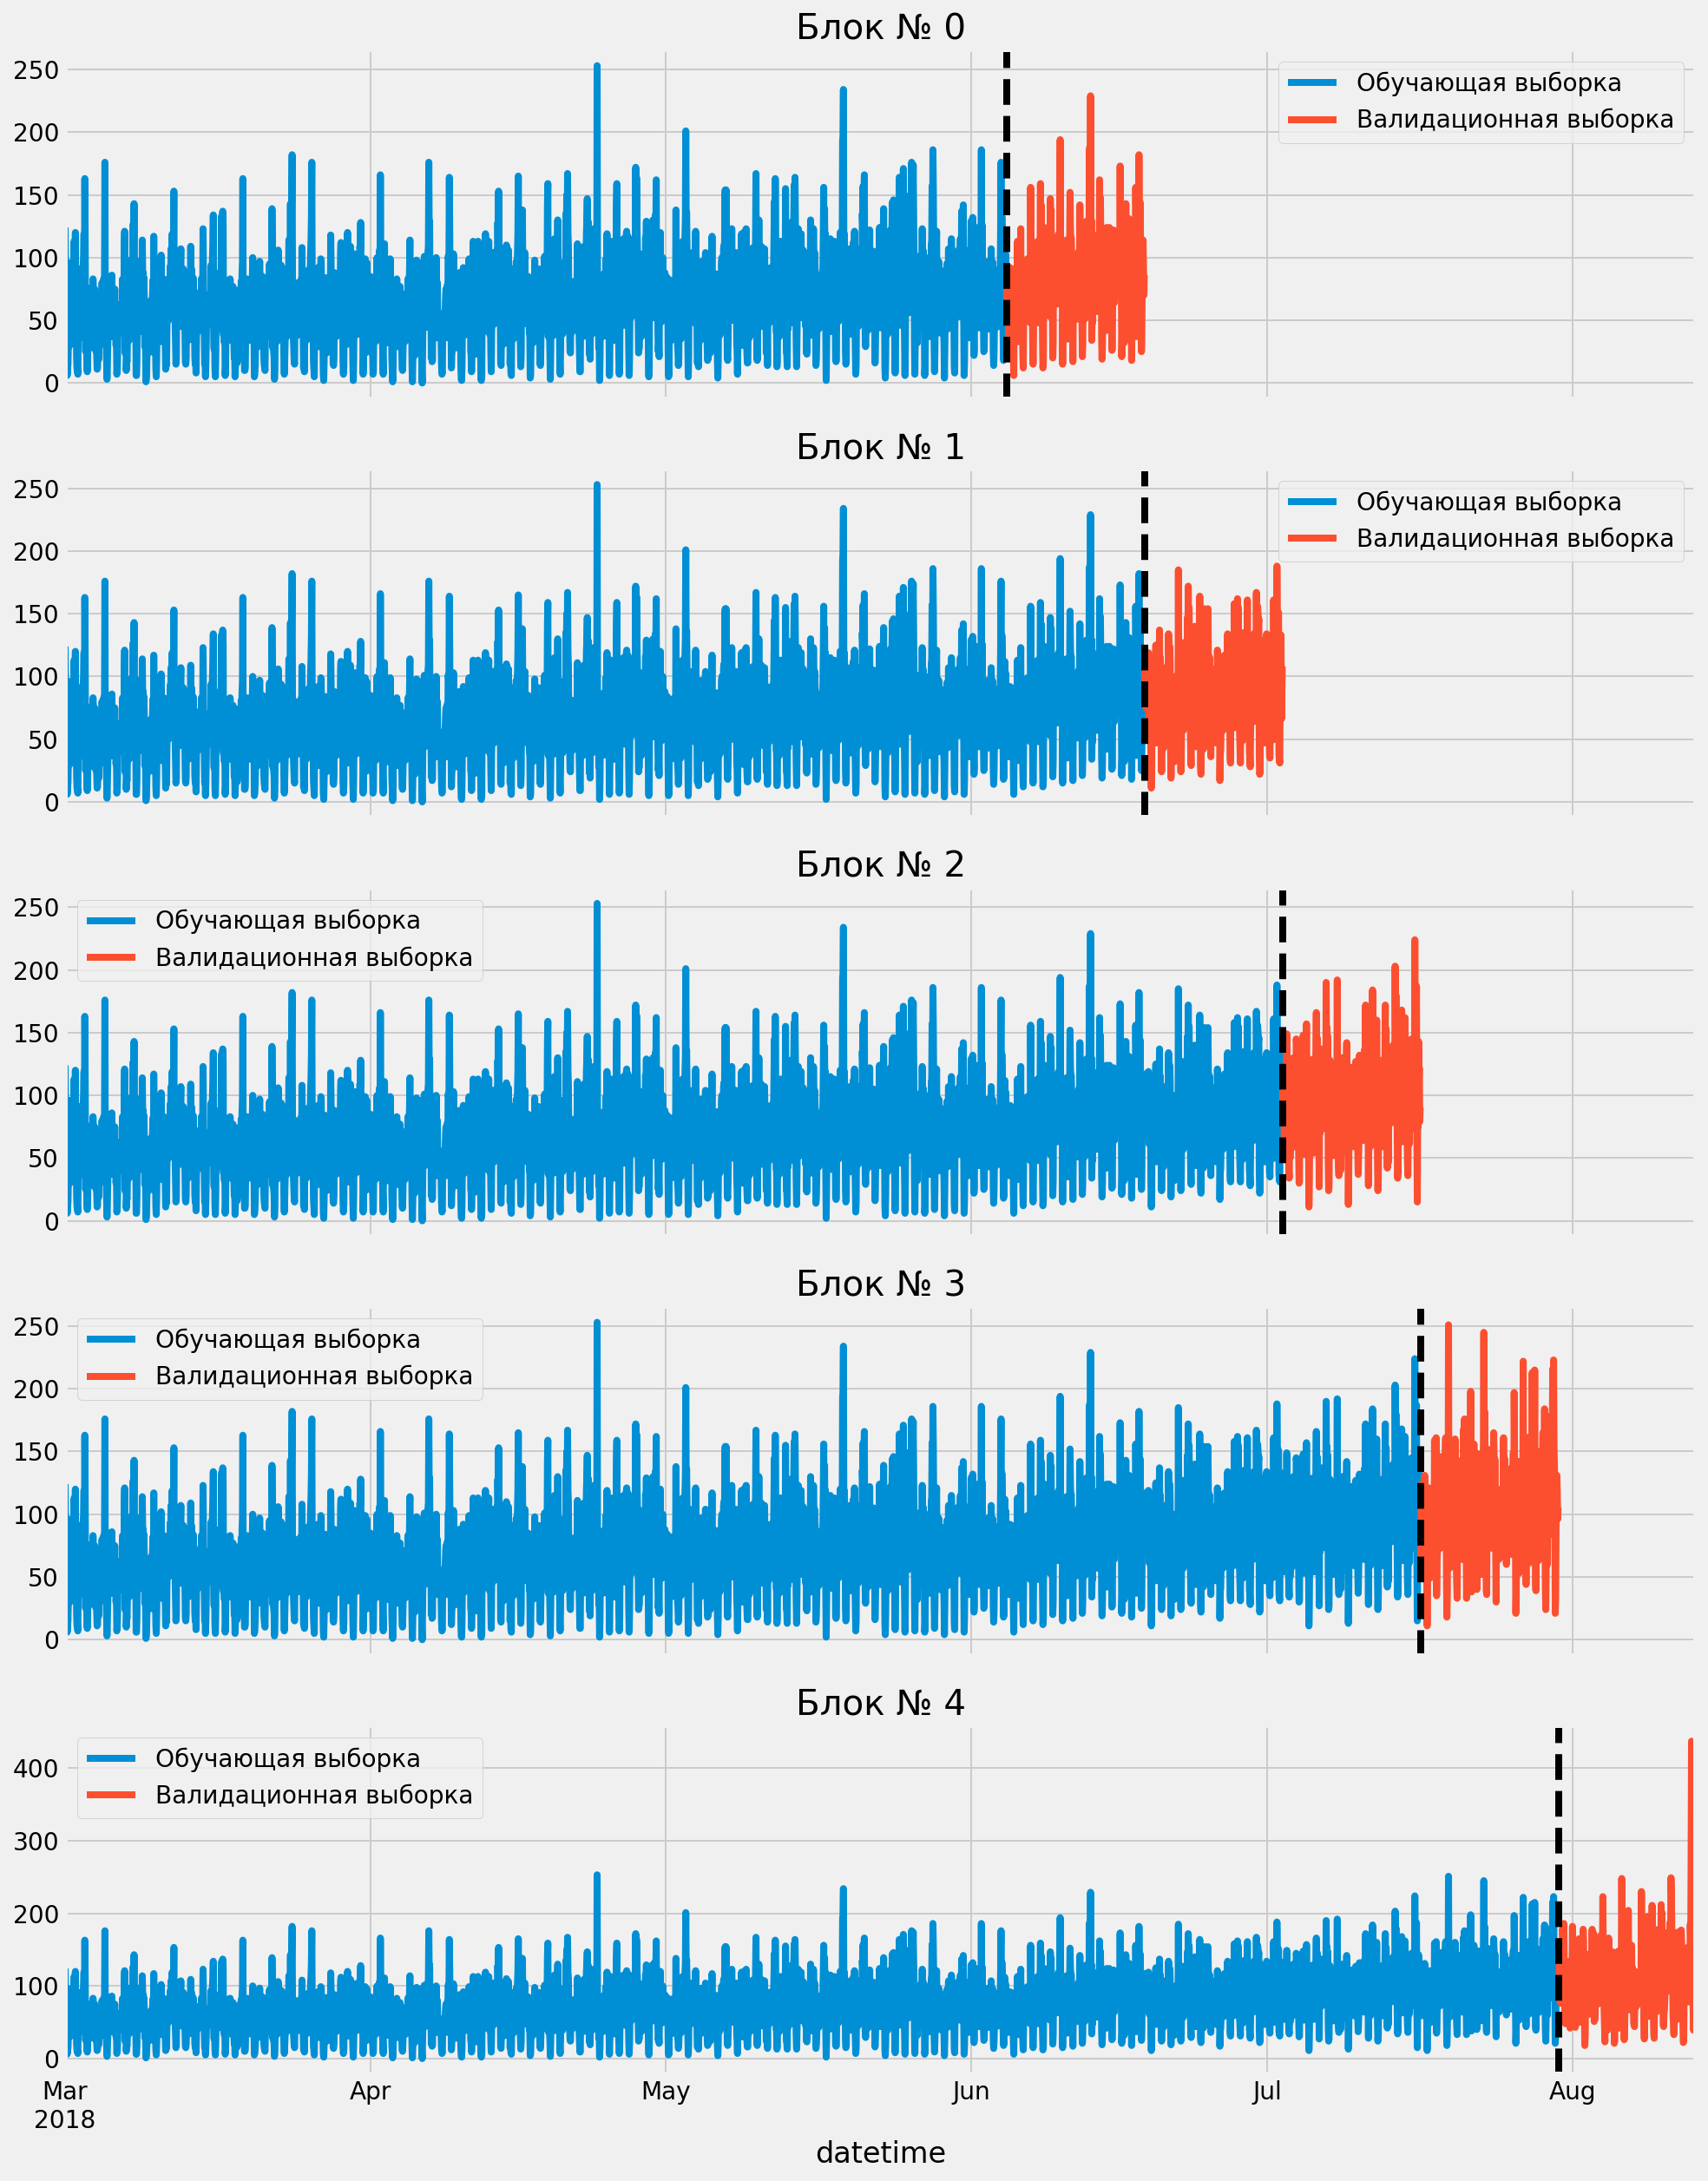

In [16]:
fig, axs = plt.subplots(5, 1, figsize=(15, 20), sharex=True)
tss = TimeSeriesSplit(5, test_size=24 * 14)
fold = 0
train_, test_ = train_test_split(
    create_features(df), test_size=0.1, shuffle=False, random_state=RND
)

for train_idx, val_idx in tss.split(train_):
    train = create_features(df).iloc[train_idx]
    test = create_features(df).iloc[val_idx]
    train["num_orders"].plot(
        title=f"Блок № {fold}", label="Обучающая выборка", ax=axs[fold], legend=True
    )
    test["num_orders"].plot(label="Валидационная выборка", ax=axs[fold], legend=True)
    axs[fold].axvline(test.index.min(), color="k", ls="--")
    fold += 1

In [17]:
test_

,num_orders,hour,day_of_week
datetime,,,
2018-08-13 14:00:00,102,14,0
2018-08-13 15:00:00,175,15,0
2018-08-13 16:00:00,144,16,0
2018-08-13 17:00:00,152,17,0
2018-08-13 18:00:00,104,18,0
...,...,...,...
2018-08-31 19:00:00,136,19,4
2018-08-31 20:00:00,154,20,4
2018-08-31 21:00:00,159,21,4


Для более качественных результатов, я ограничил размер тестовой выборки в 2 недели


Можно приступать к обучению моделей и подбору гиперпараметров. Для этого зоздадим целевую функцию, а также 2 дополнительных функции train_data_prep для корректной подготовки данных для обучения и get_scores, которая позволит реализовать кроссвалидацию для временных рядов.


In [18]:
def train_data_prep(max_lag, rolling_mean_size):
    df_full = add_lag_and_rolling_mean(create_features(df), max_lag, rolling_mean_size)
    train, test = train_test_split(
        df_full, shuffle=False, random_state=RND, test_size=0.1
    )
    X_train = train.drop("num_orders", axis=1)
    y_train = train["num_orders"]
    X_test = test.drop("num_orders", axis=1)
    y_test = test["num_orders"]
    return X_train, y_train

In [19]:
def objective(trial, model_name):
    max_lag = trial.suggest_int("max_lag", 6, 168, step=6)
    rolling_mean_size = trial.suggest_int("rolling_mean_size", 6, 168, step=6)
    if model_name == "Lasso":
        alpha = trial.suggest_float("alpha", 1e-8, 1, log=True)
        model = Lasso(alpha=alpha, random_state=RND)
    elif model_name == "DecisionTreeRegressor":
        max_depth = trial.suggest_int("max_depth", 1, 30)
        min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
        model = DecisionTreeRegressor(
            random_state=RND,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            ccp_alpha=0.001,
        )
    elif model_name == "KNeighborsRegressor":
        n_neighbors = trial.suggest_int("n_neighbors", 1, 168, step=1)
        model = KNeighborsRegressor(n_neighbors=n_neighbors)
    else:
        model = LinearRegression()
    pipe = Pipeline(steps=[("scale", StandardScaler()), ("model", model)])
    X_train, y_train = train_data_prep(max_lag, rolling_mean_size)

    scores = get_scores_sklearn(pipe, X_train, y_train)

    return np.mean(scores)


def get_scores_sklearn(model, X_train, y_train):
    scores = []
    tss = TimeSeriesSplit(n_splits=5, test_size=24 * 14)
    for train_idx, val_idx in tss.split(X_train):
        X_train_ = X_train.iloc[train_idx]
        y_train_ = y_train.iloc[train_idx]

        X_test_ = X_train.iloc[val_idx]
        y_test_ = y_train.iloc[val_idx]

        model.fit(X_train_, y_train_)

        y_pred = model.predict(X_test_)
        score = np.sqrt(mean_squared_error(y_test_, y_pred))
        scores.append(score)
    return scores


optuna.logging.set_verbosity(optuna.logging.WARN)

study_ls = optuna.create_study(study_name="Lasso", direction="minimize")
study_ls.optimize(lambda x: objective(x, "Lasso"), n_trials=200, n_jobs=-1)

study_dt = optuna.create_study(study_name="DecisionTreeRegressor", direction="minimize")
study_dt.optimize(
    lambda x: objective(x, "DecisionTreeRegressor"), n_trials=200, n_jobs=-1
)

study_kn = optuna.create_study(study_name="KNeighborsRegressor", direction="minimize")
study_kn.optimize(
    lambda x: objective(x, "KNeighborsRegressor"), n_trials=200, n_jobs=-1
)

study_lr = optuna.create_study(study_name="LinearRegression", direction="minimize")
study_lr.optimize(lambda x: objective(x, "LinearRegression"), n_trials=200, n_jobs=-1)

In [20]:
def objective(trial, model_name):
    max_lag = trial.suggest_int("max_lag", 6, 168, step=6)
    rolling_mean_size = trial.suggest_int("rolling_mean_size", 6, 168, step=6)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 0.1, log=True)

    if model_name == "CatBoostRegressor":
        l2_leaf_reg = trial.suggest_float("l2_leaf_reg", 1e-2, 1, step=1e-2)
        model = CatBoostRegressor(
            learning_rate=learning_rate,
            early_stopping_rounds=50,
            random_seed=RND,
            verbose=False,
            l2_leaf_reg=l2_leaf_reg,
        )
    else:
        max_depth = trial.suggest_int("max_depth", 2, 16)
        if model_name == "LGBMRegressor":
            model = LGBMRegressor(
                learning_rate=learning_rate,
                random_state=RND,
                verbose=0,
                max_depth=max_depth,
            )
        else:
            model = XGBRegressor(
                booster="gbtree",
                base_score=0.5,
                objective="reg:linear",
                n_estimators=1000,
                learning_rate=learning_rate,
                early_stopping_rounds=50,
                verbose_eval=False,
                max_depth=max_depth,
            )

    X_train, y_train = train_data_prep(max_lag, rolling_mean_size)

    scores = get_scores(model_name, model, X_train, y_train)

    return np.mean(scores)


def get_scores(model_name, model, X_train, y_train):
    scores = []
    tss = TimeSeriesSplit(n_splits=5, test_size=24 * 14)
    for train_idx, val_idx in tss.split(X_train):
        X_train_ = X_train.iloc[train_idx]
        y_train_ = y_train.iloc[train_idx]

        X_test_ = X_train.iloc[val_idx]
        y_test_ = y_train.iloc[val_idx]

        if model_name == "LGBMRegressor":
            model.fit(
                X_train_,
                y_train_,
                eval_set=[(X_test_, y_test_)],
                callbacks=[early_stopping(100, verbose=False), log_evaluation(0)],
            )
        else:
            model.fit(X_train_, y_train_, eval_set=[(X_test_, y_test_)], verbose=False)

        y_pred = model.predict(X_test_)
        score = np.sqrt(mean_squared_error(y_test_, y_pred))
        scores.append(score)
    return scores

Создаём сессию для модели CatBoost


In [ ]:
study_cat = optuna.create_study(direction="minimize")
study_cat.optimize(
    lambda x: objective(x, "CatBoostRegressor"),
    n_trials=100,
    n_jobs=-1,
    timeout=60 * 10,
)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Создаём сессию для модели LGBM


In [ ]:
study_lgbm = optuna.create_study(direction="minimize")
study_lgbm.optimize(
    lambda x: objective(x, "LGBMRegressor"), n_trials=100, n_jobs=-1, timeout=60 * 10
)

Создаём сессию для модели XGB


In [ ]:
study_xgb = optuna.create_study(direction="minimize")
study_xgb.optimize(
    lambda x: objective(x, "XGBRegressor"), n_trials=100, n_jobs=-1, timeout=60 * 10
)

In [ ]:
print(
    f"""
Значение RMSE на кросс-валидации 5 после оптимизации:
LinearRegression: {study_lr.best_value:.3f}
 Лучшие параметры: {study_lr.best_params}
Lasso: {study_ls.best_value:.3f}
 Лучшие параметры: {study_ls.best_params}
DecisionTreeRegressor: {study_dt.best_value:.3f}
 Лучшие параметры: {study_dt.best_params}
KNeighborsRegressor: {study_kn.best_value:.3f}
 Лучшие параметры: {study_kn.best_params}
CatBoostRegressor: {study_cat.best_value:.3f}
 Лучшие параметры: {study_cat.best_params}
LGBMRegressor: {study_lgbm.best_value:.3f}
 Лучшие параметры: {study_lgbm.best_params}
XGBRegressor: {study_xgb.best_value:.3f}
 Лучшие параметры: {study_xgb.best_params}
"""
)

### Вывод

1. Созданы функции для подготовки данных, создания блоков данных для кроссвалидации временных рядов и оптимизации средствами библиотеки Optuna;
2. Для 4 простых моделей и 3 моделей градиентного бустинга собраны лучшие параметры максимального смещения и окна скользящего средего, а также гиперпараметры самих моделей.
3. Лучшая по метрике RMSE модель среди градиентных - CatBoostRegressor, а среди обычных Lasso.


## Тестирование


Теперь проверим на тестовых данных лучшую модель:


In [ ]:
print("Лучшие параметры оптимизации:", study_ls.best_params)

In [ ]:
df_full = add_lag_and_rolling_mean(
    create_features(df),
    study_ls.best_params["max_lag"],
    study_ls.best_params["rolling_mean_size"],
)
train, test = train_test_split(df_full, shuffle=False, random_state=RND, test_size=0.1)

X_train = train.drop("num_orders", axis=1)
y_train = train["num_orders"]
X_test = test.drop("num_orders", axis=1)
y_test = test["num_orders"]

In [ ]:
# Обучаем модель
model_lasso = Lasso(alpha=study_ls.best_params["alpha"], random_state=RND)
model_lasso.fit(X_train, y_train)
# Тут ошибка вывода параметров модели почему-то возникла

Итоговая метрика на тесте


In [ ]:
mean_squared_error(y_test, model_lasso.predict(X_test)) ** 0.5

Модель на адекватность проверим через предсказание среднего на обучающей выборке:


In [ ]:
y_baseline_pred = np.full(len(y_test), fill_value=y_train.mean())
mean_squared_error(y_test, y_baseline_pred) ** 0.5

Модель полностью адекватна.


In [ ]:
plt.plot(
    y_test.index.tolist(),
    y_test,
)
plt.plot(y_test.index.tolist(), model_lasso.predict(X_test))
plt.legend(["Тест", "Lasso"])
plt.title("Предсказание в сравнении с реальными данными")
plt.xlabel("Дата")
plt.ylabel("Кол-во заказов")
plt.xticks(rotation=45)
# Название добавил после

### Вывод

Лучшая модель по критерию минимума RMSE - модель CatboostRegressor, но в конечном итоге выбрана более простая модель Lasso. Существенное влияние на результат моделирования оказывает час. Модель полностью адекватна, поскольку её метрика превосходит метрику baseline модели(34.264 < 84.8).


## Общие выводы

1. Данные загружены, предварительно изучены и преобразованы к более удобному виду.
2. Данные изучены на наличие трендов, сезонности и шума, с помощью дополнительных функций из даты искуственно извлечены новые признаки. Обнаружены общие тенденции к увеличению количества заказов в различные временные промежутки с течением времени. Важными с позиции количества заказов можно считать ночное время и дневное время перед окончанием рабочего времени.
3. Обучены и оптимизированы на кроссвалидации модели CatBoost, LGBM и XGBf а также ряд неградиентных моделей, среди них лучшей с позиции метрики RMSE оказался CatBoost.
4. Поскольку модель Lasso более проста и даёт метрику RMSE сопоставимую с CatBoost для конечного тестирования будет выбрана она. Lasso доказала свою адекватность в сравнении с baseline моделью.


## Чек-лист проверки


- [x] Jupyter Notebook открыт
- [x] Весь код выполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Данные загружены и подготовлены
- [x] Данные проанализированы
- [x] Модель обучена, гиперпараметры подобраны
- [x] Качество моделей проверено, выводы сделаны
- [x] Значение _RMSE_ на тестовой выборке не больше 48
